In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import datetime as dt
from Dates import from_excel_date

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tick

import warnings
warnings.filterwarnings('ignore')

from RiskManagement import *

pd.options.display.float_format = '{:,.2f}'.format

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/computation/expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.8.7' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arrays/masked.py:56: UserWarning: Pandas requires version '1.4.2' or newer of 'bottleneck' (version '1.3.7' currently installed).
  from pandas.core import (


# Manual (Bauza)

In [2]:
ann_vol = pd.Series({'CLP': 0.082, 'COP': 0.30, 'PEN': 0.0683,
                     'MXN': 0.1349, 'BRL': 0.02195, 'USD': 0.01447})
norm_vol = pd.Series({'CLP': 1.20, 'COP': 3.0, 'PEN': 0.34,
                      'MXN': 1.40, 'BRL': 2.0, 'USD': 0.46})
position = pd.Series({'CLP': 0.0, 'COP': -10_000, 'PEN': 0.0,
                      'MXN': -20_000, 'BRL': 0.0, 'USD': 0.0})
manual_var(ann_vol, norm_vol, position)

,Vol (Ann.),Normalized,Position,Daily Vol (bps),Unit Variance,VaR (97.5%),Risk Weights Squared
CLP,0.08,1.20,0.00,7.56,57.14,0.00,0.00
COP,0.30,3.00,"-10,000.00",18.90,357.14,"370,405.18","35,714,285,714.29"
PEN,0.07,0.34,0.00,2.14,4.59,0.00,0.00
MXN,0.13,1.40,"-20,000.00",8.82,77.78,"345,711.50","31,111,111,111.11"
BRL,0.02,2.00,0.00,12.60,158.73,0.00,0.00
USD,0.01,0.46,0.00,2.90,8.40,0.00,0.00
Total,0.62,8.40,"-30,000.00",52.92,663.78,"716,116.69","2,520,000,000,000.00"


In [3]:
ann_vol = pd.Series({'CLP': 0.082, 'COP': 0.0826, 'PEN': 0.0683,
                     'MXN': 0.1349, 'BRL': 0.02195, 'USD': 0.01447})
norm_vol = pd.Series({'CLP': 1.20, 'COP': 2.0, 'PEN': 0.34,
                      'MXN': 1.40, 'BRL': 2.0, 'USD': 0.46})
position = pd.Series({'CLP': 150_000, 'COP': -10_000, 'PEN': 0.0,
                      'MXN': 0.0, 'BRL': 0.0, 'USD': 0.0})
custom_factors = pd.Series({'CLP': 1.0, 'COP': 1.5, 'PEN': 1.0,
                            'MXN': 1.0, 'BRL': 1.0, 'USD': 1.0})
manual_var(ann_vol, norm_vol, position, custom_factors=custom_factors)

,Vol (Ann.),Normalized,Position,Daily Vol (bps),Unit Variance,VaR (97.5%),Risk Weights Squared
CLP,0.08,1.20,"150,000.00",7.56,57.14,"2,222,431.10","1,285,714,285,714.29"
COP,0.08,2.00,"-10,000.00",12.60,158.73,"370,405.18","15,873,015,873.02"
PEN,0.07,0.34,0.00,2.14,4.59,0.00,0.00
MXN,0.13,1.40,0.00,8.82,77.78,0.00,0.00
BRL,0.02,2.00,0.00,12.60,158.73,0.00,0.00
USD,0.01,0.46,0.00,2.90,8.40,0.00,0.00
Total,0.40,7.40,"140,000.00",46.62,465.37,"2,592,836.28","42,591,111,111,111.11"


# Risk Monitor

In [4]:
spot = pd.read_excel('Data/FX.xlsx', sheet_name='Spot', index_col=0)
spot.drop('Date', inplace = True)
spot.index.rename = 'Date'
spot.index = spot.index.map(from_excel_date)
spot.dropna(inplace = True)

returns = np.log((spot / spot.shift(1)).astype(float)).dropna()
N = len(returns.columns)
weights = pd.Series([1/N]*N, index = returns.columns)
portfolio = returns.dot(weights)


In [5]:
# ============================
# ======== PARAMETERS ========
# ============================
alpha = 0.95 # Confidence level
z_score = norm.ppf(1-alpha)
window = 21*12 # Window used to get VaR
notional = 10_000_000 # 10M USD
n_bootstrap = 100 # Number of boostrap iterations to compute confidence intervals

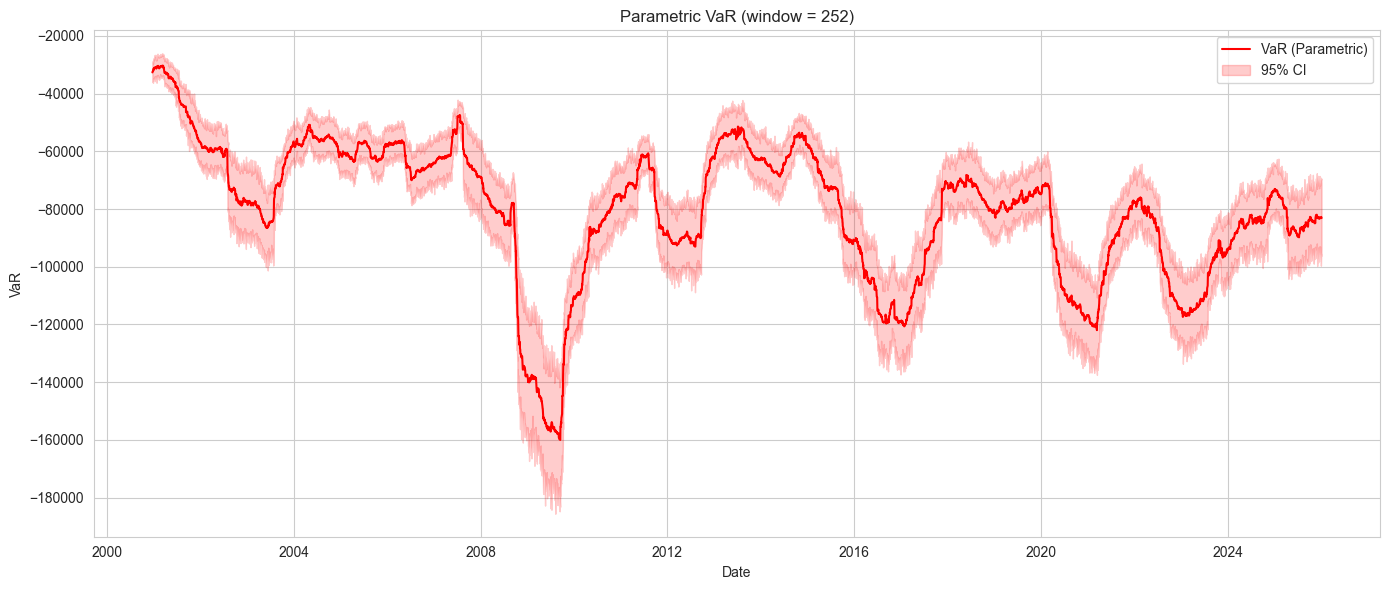

Currency
2025-12-24   -82,852.49
2025-12-26   -82,852.36
2025-12-29   -82,742.60
2025-12-30   -83,137.40
2025-12-31   -83,147.06
dtype: float64

In [6]:
# Parametric VaR
parametric, param_lower, param_upper = parametric_var(portfolio, alpha, notional, window = window, n_bootstrap = n_bootstrap)
plot_with_confidence_interval(parametric, param_lower, param_upper, f'Parametric VaR (window = {window})', label = 'VaR (Parametric)', ylabel = 'VaR')
parametric.tail()

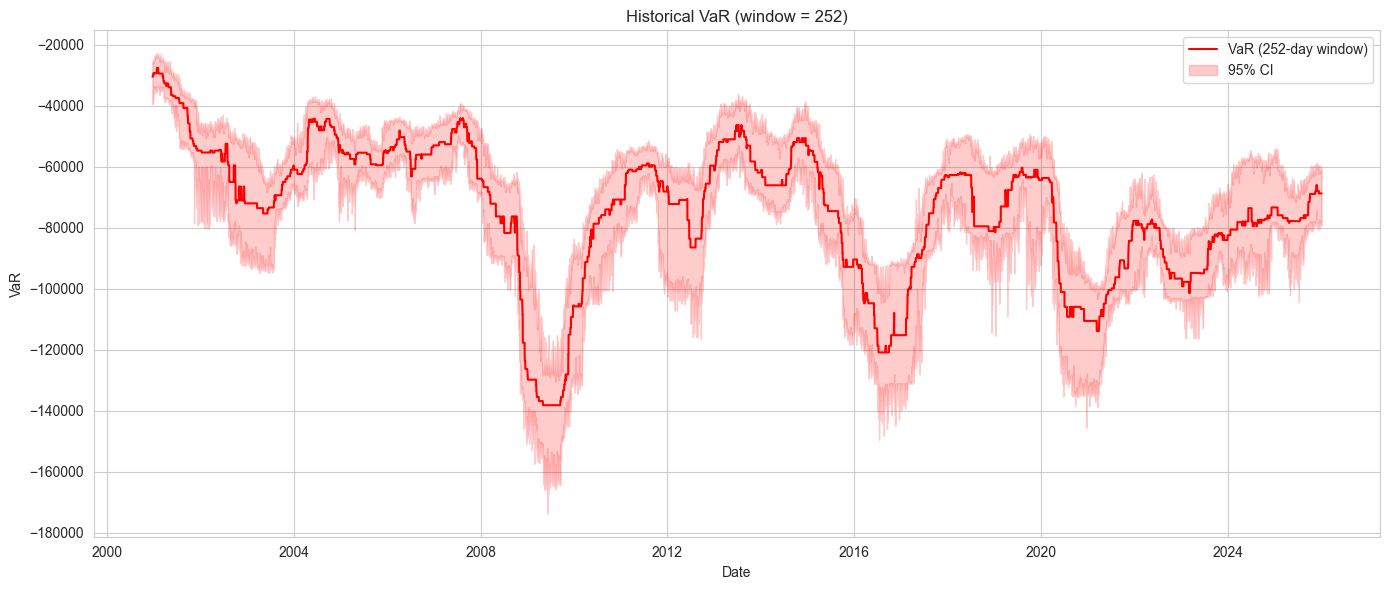

Currency
2025-12-24   -68,722.93
2025-12-26   -68,722.93
2025-12-29   -68,722.93
2025-12-30   -68,722.93
2025-12-31   -68,722.93
dtype: float64

In [7]:
# Historical
historical, hist_low, hist_up = historical_var(portfolio, alpha, notional, window = window, n_bootstrap = n_bootstrap)
plot_with_confidence_interval(historical, hist_low, hist_up, f'Historical VaR (window = {window})', label = f'VaR ({252}-day window)', ylabel = 'VaR')
historical.tail()

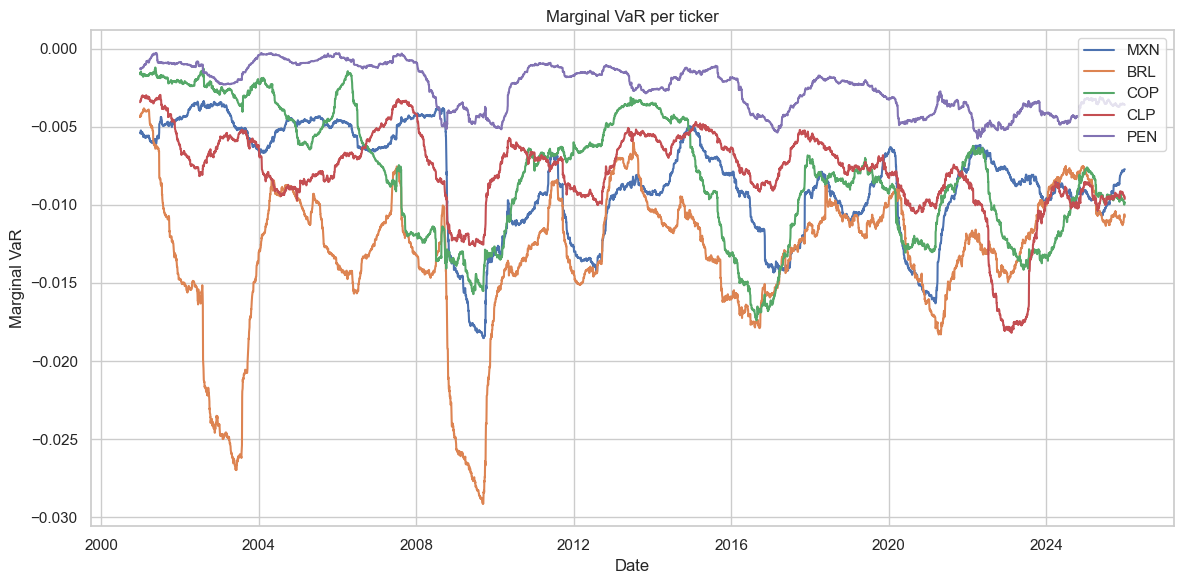

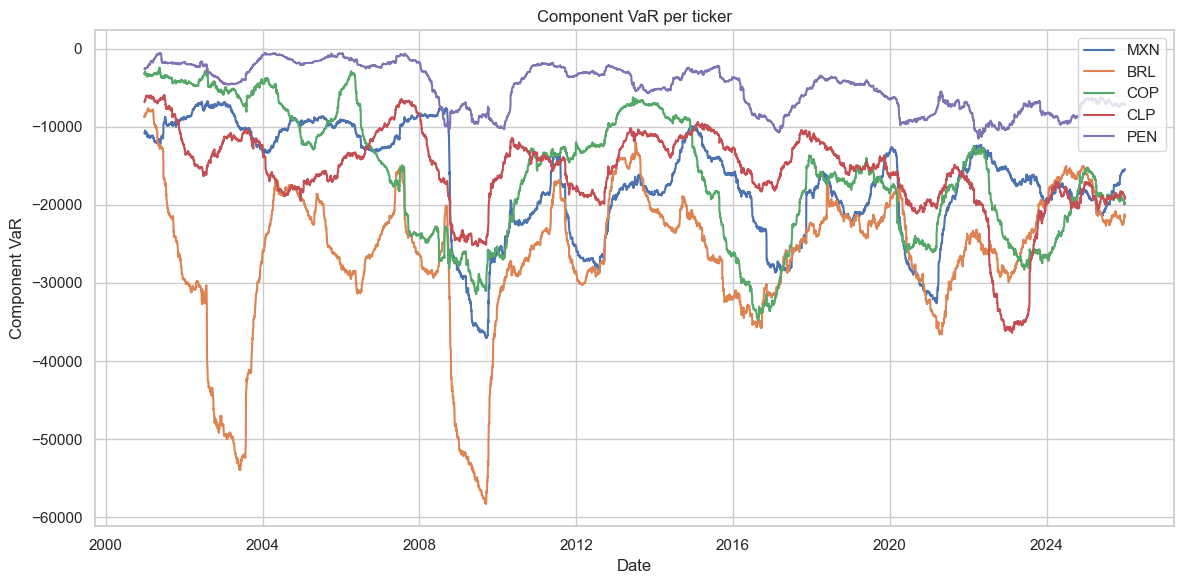

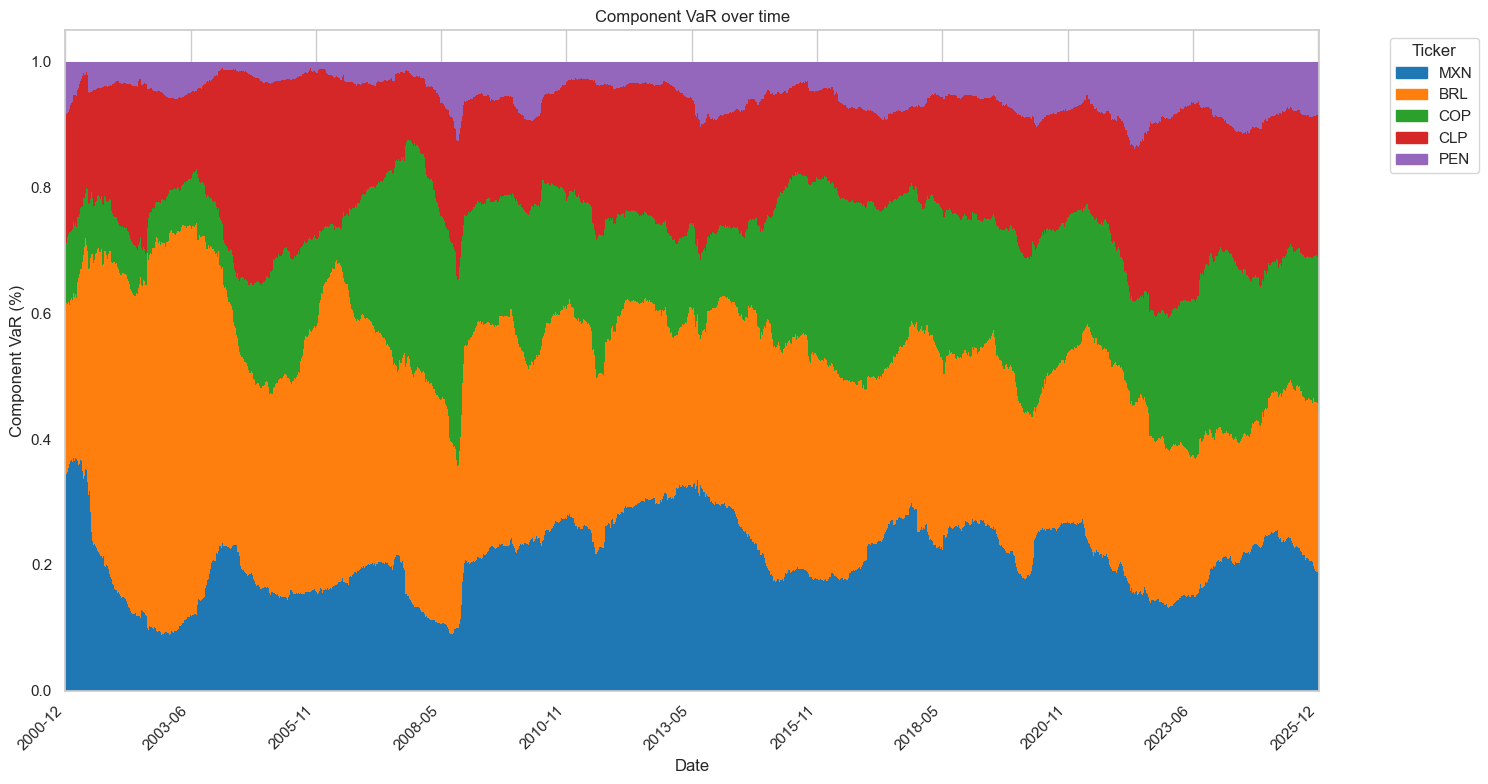

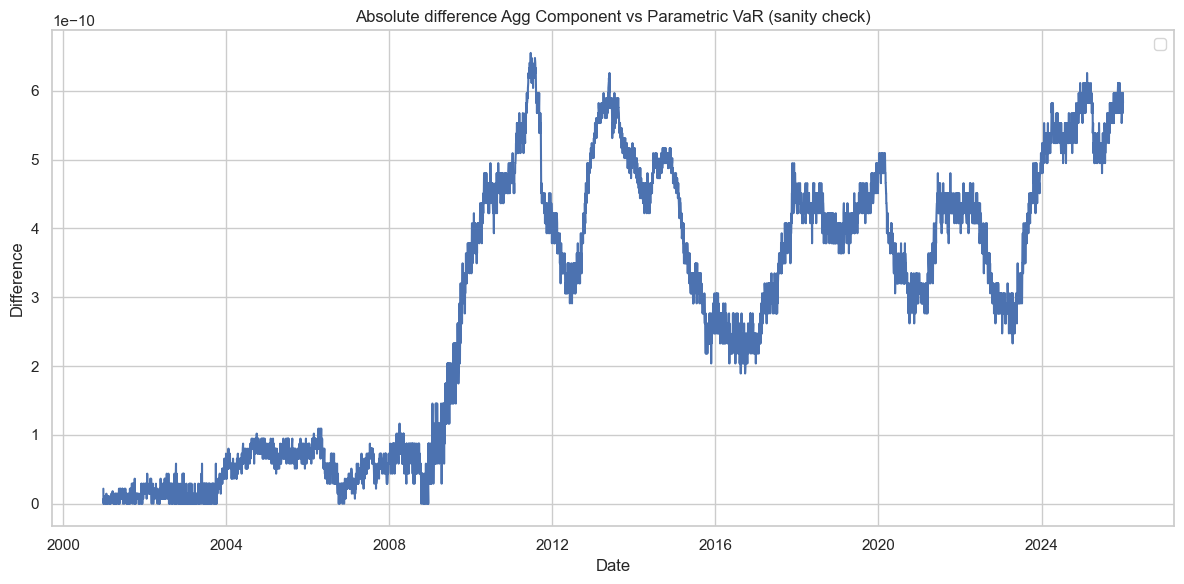

In [8]:
marginal, component, diff = parametric_marginal_var(returns, weights, alpha, notional, parametric = parametric, window=window)

In [9]:
end_date = portfolio.index[-1]
VaRs = [parametric[end_date].item(), historical[end_date].item()]
back = pd.DataFrame(columns = [f'VaR({alpha})', 'Exceptions (%)', 'Unexpected Loss'],
             index = [f'Parametric ({window})', f'Historical ({window})'])

for VaR, name in zip(VaRs, back.index):
  back.loc[name] = [VaR] + list(backtest(portfolio * notional, VaR, window = 500))

back['Exceptions (%)'] *= 100
back

,VaR(0.95),Exceptions (%),Unexpected Loss
Parametric (252),"-83,147.06",2.40,"-146,250.39"
Historical (252),"-68,722.93",5.60,"-160,674.51"
